## Imports

In [1]:
import os
import joblib
import sys
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf

In [2]:
# Завантаження даних
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
origin_dim = x_train.shape[1]

# Нормалізація
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape to flat
x_train_flat = x_train.reshape((len(x_train), -1))
x_test_flat = x_test.reshape((len(x_test), -1))

x_train_flat.shape

(60000, 784)

## Pipeline

In [34]:
# AE
lat_dim_ae = 100
inputs = tf.keras.layers.Input(shape=(784,))
encoded = tf.keras.layers.Dense(128, activation='relu')(inputs)
encoded = tf.keras.layers.Dense(lat_dim_ae, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = tf.keras.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

start_time = time.time()
autoencoder.fit(x_train_flat, x_train_flat, epochs=10)
AE_train_time = time.time() - start_time

x_train_ae = autoencoder.predict(x_train_flat)
x_test_ae = autoencoder.predict(x_test_flat)
x_train_ae.shape

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0214
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0086
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0065
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0055
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0049
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0046
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0042
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0040
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0038
Epoch 10/10
313/313 [==============================] - 0s 978us/step


(60000, 784)

In [8]:
# SVD
lat_dim_svd = 12
svd = TruncatedSVD(n_components=lat_dim_svd*lat_dim_svd)

start_time = time.time()
svd.fit(x_train_ae)
# svd.fit(x_train_flat)
svd_train_time = time.time() - start_time

x_train_svd = svd.transform(x_train_ae)
x_test_svd = svd.transform(x_test_ae)
# x_train_svd = svd.transform(x_train_flat)
# x_test_svd = svd.transform(x_test_flat)
x_train_svd.shape

(60000, 144)

In [22]:
x_train_reduced = x_train_svd
x_test_reduced = x_test_svd

In [35]:
print("AE train time:", AE_train_time)
print("SVD train time:", svd_train_time)

AE train time: 37.07005071640015
SVD train time: 1.758035659790039


## evaluation on MLPClassifier

### MLP model

In [4]:
def make_mlp_model(x_train, y_train):
    mlp_model = MLPClassifier(solver='lbfgs')
    mlp_model.fit(x_train, y_train)
    return mlp_model

### Other Functions

In [5]:
def print_model_size(model_to_save):
    file_path =  'my_model.joblib'
    joblib.dump(model_to_save, file_path)
    
    file_size_bytes = os.path.getsize(file_path)
    file_size_kb = file_size_bytes / 1024
    print(f"Розмір файлу-моделі на диску: {file_size_kb:.2f} KB")
    if os.path.isfile(file_path):
        os.remove(file_path)

In [11]:
def my_score(mlp_model1, x_test):
    start_time = time.time()
    y_pred = mlp_model1.predict(x_test)
    print(f"Час затрачений для передбачення всіх x_test({len(x_test)}) - {round(time.time() - start_time, 3)} сек")

    size_in_bytes = sys.getsizeof(mlp_model1)
    print(f"Розмір моделі в оперативній пам'яті: {size_in_bytes} байт")
    print_model_size(mlp_model1)
    
    print("classification report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Матриця помилок')
    plt.xlabel('Передбачений клас')
    plt.ylabel('Справжній клас')
    plt.show()

In [7]:
def performance_evaluation(x_train, x_test):
    start_time = time.time()
    mlp_model = make_mlp_model(x_train, y_train)
    print(f"Час навчання mlp - {round(time.time() - start_time, 2)}")
    my_score(mlp_model, x_test)

### Performance evaluation - original data

Час навчання mlp - 28.337270259857178
Час затрачений для передбачення всіх x_test(10000) - 0.03600001335144043 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу на диску: 625.42 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



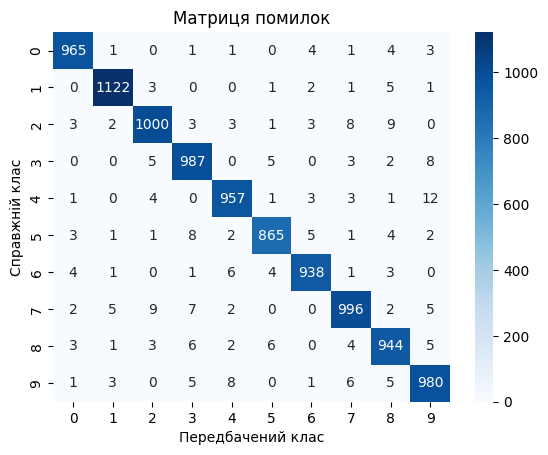

In [17]:
performance_evaluation(x_train_flat,x_test_flat)

### Performance evaluation - reduced data - only AE

Час навчання mlp - 37.28
Час затрачений для передбачення всіх x_test(10000) - 0.039 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу-моделі на диску: 625.42 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.98      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.97      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



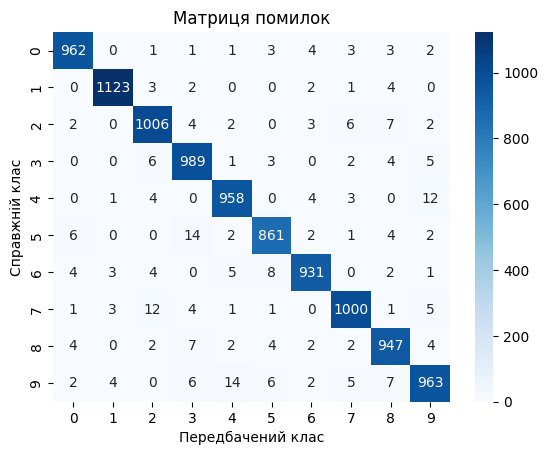

In [36]:
performance_evaluation(x_train_ae,x_test_ae)

### Performance evaluation - reduced data - only SVD

Час навчання mlp - 17.29539179801941
Час затрачений для передбачення всіх x_test(10000) - 0.01251983642578125 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу на диску: 125.41 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



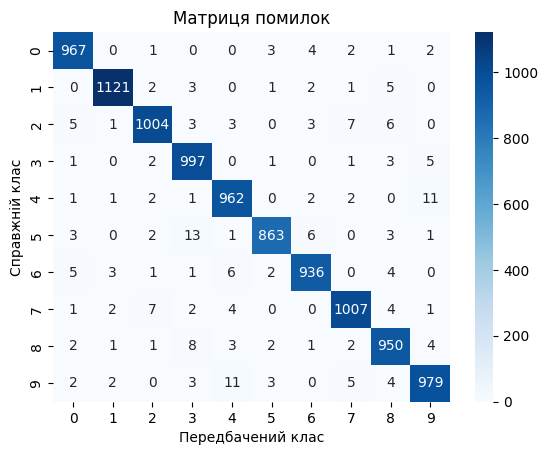

In [20]:
# note: use x train without AE
# performance_evaluation(x_train_svd,x_test_svd)

### Performance evaluation - reduced data

c:\Program Files\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Час навчання mlp - 19.786543369293213
Час затрачений для передбачення всіх x_test(10000) - 0.010999679565429688 сек
Розмір моделі в оперативній пам'яті: 56 байт
Розмір файлу на диску: 125.41 KB
classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.95      0.96      1032
           3       0.93      0.94      0.94      1010
           4       0.95      0.95      0.95       982
           5       0.94      0.95      0.94       892
           6       0.97      0.98      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.92      0.92      0.92       974
           9       0.94      0.93      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



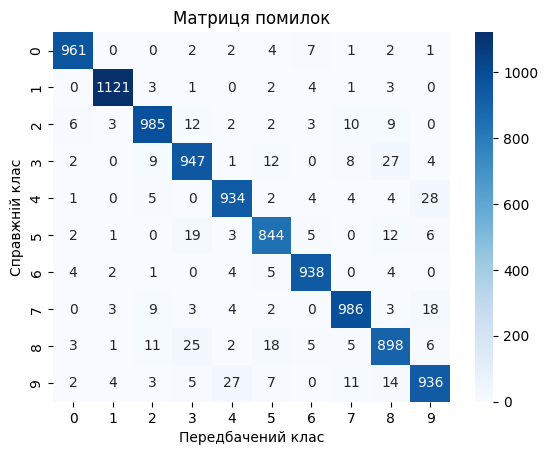

In [24]:
performance_evaluation(x_train_reduced,x_test_reduced)

### print all data size

In [45]:
x1 = sys.getsizeof(x_train)
x2 = sys.getsizeof(x_train_ae)
x3 = sys.getsizeof(x_train_reduced)
print(f"Розмір оригінальних даних       - { x1 } байт")
print(f"Розмір після автоенкодера       - { x2 } байт ({x2/x1})")
print(f"Розмір після автоенкодера + SVD - { x3 } байт ({x3/x2})")

Розмір оригінальних даних       - 188160144 байт
Розмір після автоенкодера       - 188160128 байт (0.9999999149660515)
Розмір після автоенкодера + SVD - 34560128 байт (0.1836740247115478)


# visualisation

In [43]:
x_ae = x_train_ae.reshape(len(x_train_ae), origin_dim, -1)
x_ae.shape

(60000, 28, 28)

In [44]:
X_recovered = svd.inverse_transform(x_train_svd)
x_svd = X_recovered.reshape(len(X_recovered), origin_dim, -1)
x_svd.shape

(60000, 28, 28)

In [45]:
x_svd_lat = x_train_svd.reshape(len(x_train_svd), lat_dim_svd, -1)
x_svd_lat.shape

(60000, 12, 12)

In [28]:
def plot_classes(x,y):
    unique_classes = np.unique(y)
    nrows, ncols = 1, 10
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5), squeeze=False)

    # Для кожного унікального класу
    for i, digit_class in enumerate(unique_classes):
        row, col = i // ncols, i % ncols
        ax = axes[row][col]
        
        class_indices = np.where(y == digit_class)[0]
        digit_index = class_indices[0]
        digit_data = x[digit_index]
            
        ax.imshow(digit_data, cmap='gray')
        ax.set_title(f"Клас: {digit_class}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

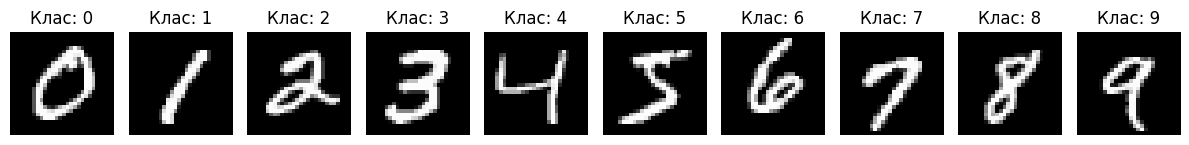

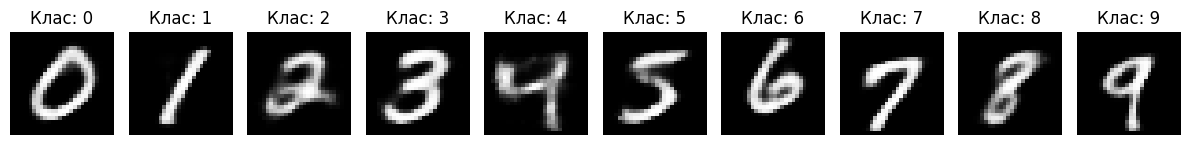

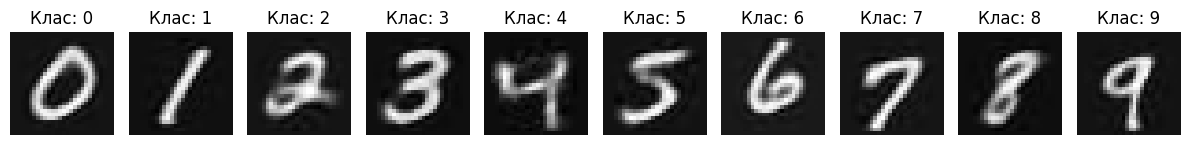

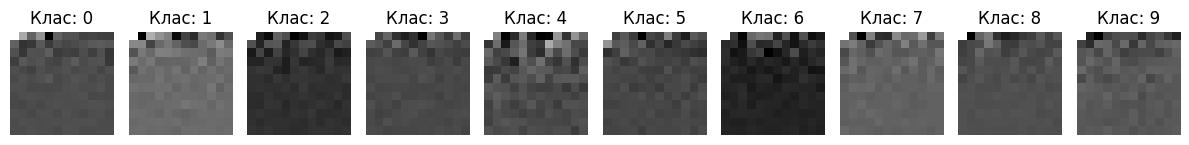

In [46]:
plot_classes(x_train,y_train)
plot_classes(x_ae,y_train)
plot_classes(x_svd,y_train) # after svd inverse
plot_classes(x_svd_lat,y_train) # clean svd

# chart

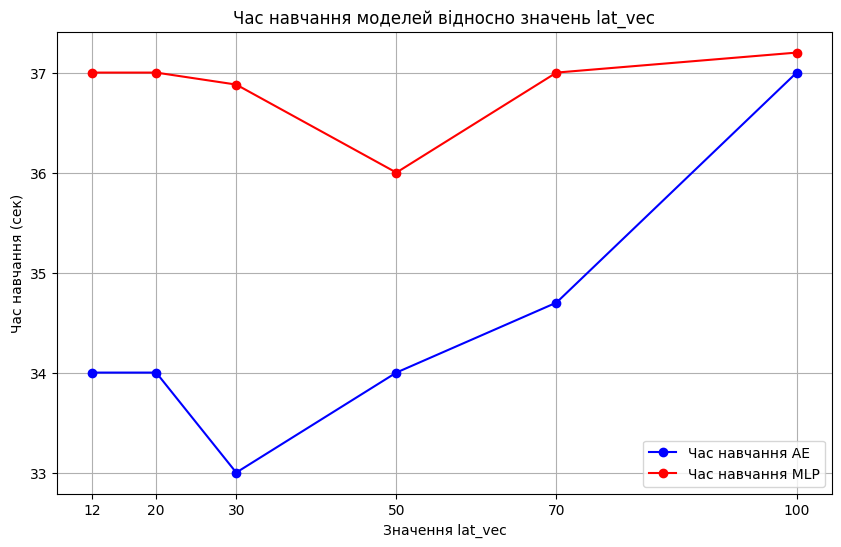

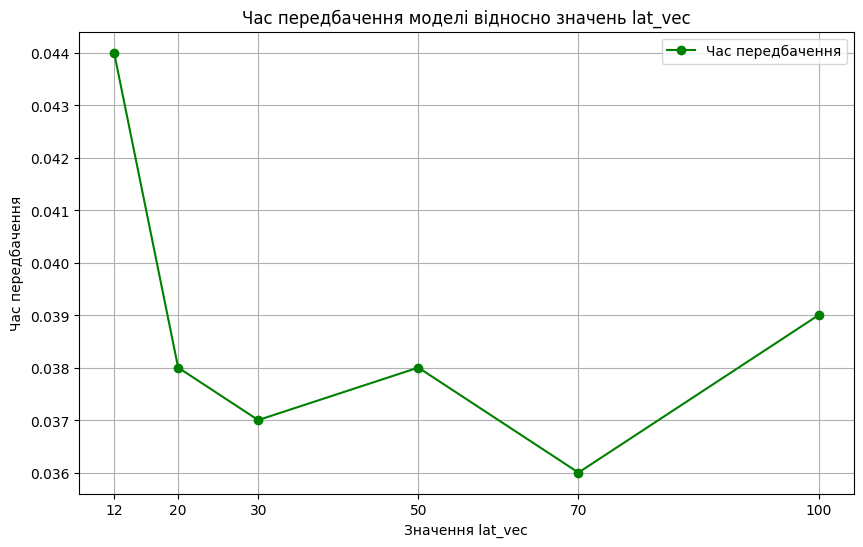

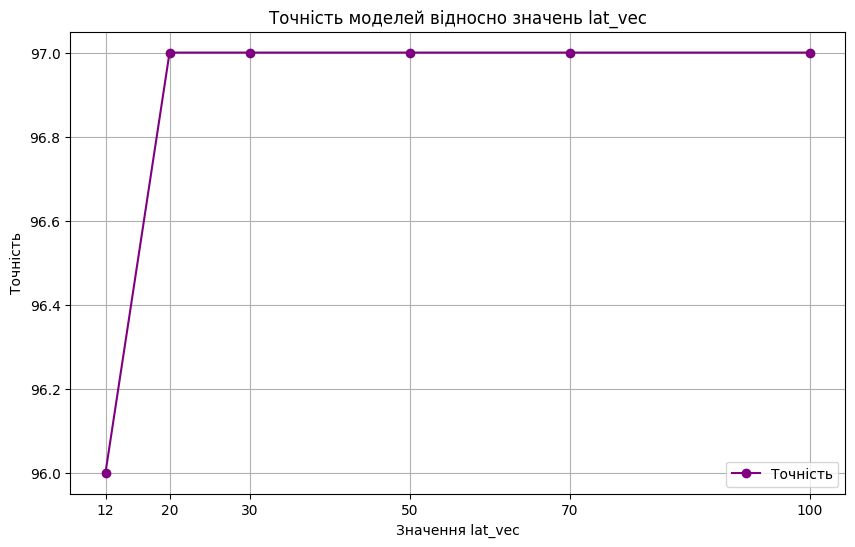

In [38]:
import matplotlib.pyplot as plt

# Значення параметрів
lat_vec =           [12, 20, 30, 50, 70, 100]
ae_training_time =  [34, 34, 33, 34, 34.7, 37]  # Час навчання AE
mlp_training_time = [37, 37, 36.88, 36, 37, 37.2]  # Час навчання MLP
prediction_time =   [0.044, 0.038, 0.037, 0.038, 0.036, 0.039]  # Час передбачення
accuracy =          [96, 97, 97, 97, 97, 97]  # Точність

# Побудова графіку для часу навчання AE та MLP
plt.figure(figsize=(10, 6))

plt.plot(lat_vec, ae_training_time, marker='o', color='blue', label='Час навчання AE')
plt.plot(lat_vec, mlp_training_time, marker='o', color='red', label='Час навчання MLP')

plt.xlabel('Значення lat_vec')
plt.ylabel('Час навчання (сек)')
plt.title('Час навчання моделей відносно значень lat_vec')
plt.xticks(lat_vec)
plt.grid(True)
plt.legend()

plt.show()

# Побудова графіку для часу передбачення
plt.figure(figsize=(10, 6))

plt.plot(lat_vec, prediction_time, marker='o', color='green', label='Час передбачення')

plt.xlabel('Значення lat_vec')
plt.ylabel('Час передбачення')
plt.title('Час передбачення моделі відносно значень lat_vec')
plt.xticks(lat_vec)
plt.grid(True)
plt.legend()

plt.show()

# Побудова графіку для точності
plt.figure(figsize=(10, 6))


plt.plot(lat_vec, accuracy, marker='o', color='purple', label='Точність')

plt.xlabel('Значення lat_vec')
plt.ylabel('Точність')
plt.title('Точність моделей відносно значень lat_vec')
plt.xticks(lat_vec)
plt.grid(True)
plt.legend()

plt.show()


# TODO 
- read: https://www.kaggle.com/code/jonathankristanto/experimenting-with-pca-on-mnist-dataset
- як впливає автоенкодер - не дуже добре
- доп. алгоритими до пайплайну - pass
- різні методи оцінки якості редукції +
    - розмір даних після редукції +
    - модель:
        - час навчання +
        - швидкість відгуку моделі +
        - розмір моделі на диску +
        - розмір моделі в оперативці +
- дослідити для яких алгоритмів (дерева рішень, класифікація) ми отримаємо перевагу від редукції

- архітектура AE
- AE збільшити кількість latt vec
- підібрати параметри для SVD, зробити графік (звітність)


---
дані після SVD захищені (шифрування)

На майбутнє: робота з RGB